In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from scipy import stats

# 读取数据
df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
df['date'] = pd.to_datetime(df['date'])

# 添加风力大于4级的特征
df['strong_wind'] = df['wind_power'].apply(lambda x: 1 if str(x).replace('级','').isdigit() and int(str(x).replace('级','')) >= 4 else 0)

# 添加天气one-hot编码
def split_weather(weather):
    if pd.isna(weather):
        return []
    return str(weather).split('-')

all_weather_types = set()
for weather in df['weather'].dropna():
    all_weather_types.update(split_weather(weather))

for weather_type in all_weather_types:
    df[f'weather_{weather_type}'] = df['weather'].apply(lambda x: 1 if pd.notna(x) and weather_type in split_weather(x) else 0)

# 选择需要分析相关性的列
target_cols = ['density_mean_y', 'density_lower_y', 'density_upper_y', 
               'chla_mean', 'chla_lower', 'chla_upper']

# 选择所有特征列
exclude_cols = target_cols + ['date', 'density_mean_x', 'density_lower_x', 'density_upper_x', 'weather']
feature_cols = df.select_dtypes(include=[np.number]).columns.difference(exclude_cols)

# 计算综合特征重要性
feature_importance = {}
for target in target_cols:
    feature_importance[target] = {}
    
    for feature in feature_cols:
        # Spearman相关系数
        spearman_corr = df[feature].corr(df[target], method='spearman')
        
        # 互信息得分
        mi_score = mutual_info_regression(df[[feature]], df[target], random_state=42)[0]
        
        # 滞后相关性
        max_lag_corr = 0
        best_lag = 0
        for lag in range(1, 16):
            lag_corr = df[feature].shift(lag).corr(df[target], method='spearman')
            if not np.isnan(lag_corr) and abs(lag_corr) > abs(max_lag_corr):
                max_lag_corr = lag_corr
                best_lag = lag
                
        # 综合评分 = 0.4*相关系数 + 0.3*互信息 + 0.3*最大滞后相关
        composite_score = 0.4 * abs(spearman_corr) + 0.3 * mi_score + 0.3 * abs(max_lag_corr)
        
        feature_importance[target][feature] = {
            'composite_score': composite_score,
            'spearman_corr': spearman_corr,
            'mi_score': mi_score,
            'max_lag_corr': max_lag_corr,
            'best_lag': best_lag
        }
# 创建结果表格
results = []
for target in target_cols:
    sorted_features = sorted(feature_importance[target].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:15]
    
    for feature, metrics in sorted_features:
        results.append({
            '目标变量': target,
            '特征': feature,
            '综合得分': round(metrics['composite_score'], 3),
            'Spearman相关系数': round(metrics['spearman_corr'], 3),
            '互信息得分': round(metrics['mi_score'], 3),
            '最大滞后相关': round(metrics['max_lag_corr'], 3),
            '最佳滞后期(天)': metrics['best_lag']
        })

# 输出结果表格
results_df = pd.DataFrame(results)
print("\n各目标变量的Top 15影响因子:")
print(results_df.to_string(index=False))



各目标变量的Top 15影响因子:
           目标变量              特征  综合得分  Spearman相关系数  互信息得分  最大滞后相关  最佳滞后期(天)
 density_mean_y     temperature 0.533         0.561  0.450   0.580         7
 density_mean_y min_temperature 0.476         0.546  0.282   0.577         4
 density_mean_y max_temperature 0.469         0.533  0.267   0.585         3
 density_mean_y          oxygen 0.426        -0.440  0.329  -0.505        15
 density_mean_y              TN 0.412        -0.442  0.316  -0.468         4
 density_mean_y    conductivity 0.411        -0.412  0.401  -0.420         5
 density_mean_y              pH 0.328         0.335  0.306   0.342         1
 density_mean_y             aqi 0.256        -0.351  0.078  -0.309         1
 density_mean_y        aqiLevel 0.247        -0.330  0.095  -0.288         1
 density_mean_y              TP 0.241         0.272  0.216   0.224         1
 density_mean_y    permanganate 0.230         0.235  0.272   0.182         1
 density_mean_y       turbidity 0.227         0.290  0.15

2024-11-13 08:49:28,697 - INFO - Successfully loaded data file
2024-11-13 08:49:28,697 - INFO - Start training model, sequence length: 14, prediction steps: 7
2024-11-13 08:49:28,704 - INFO - Number of density features: 10
2024-11-13 08:49:28,705 - INFO - Density features: ['temperature', 'min_temperature', 'max_temperature', 'oxygen', 'TN', 'conductivity', 'pH', 'aqi', 'aqiLevel', 'TP']
2024-11-13 08:49:35,843 - INFO - Epoch 10/200, Average Loss for target 1: 0.0032
2024-11-13 08:49:38,759 - INFO - Epoch 20/200, Average Loss for target 1: 0.0028
2024-11-13 08:49:42,033 - INFO - Epoch 30/200, Average Loss for target 1: 0.0025
2024-11-13 08:49:44,947 - INFO - Epoch 40/200, Average Loss for target 1: 0.0027
2024-11-13 08:49:47,341 - INFO - Epoch 50/200, Average Loss for target 1: 0.0023
2024-11-13 08:49:50,205 - INFO - Epoch 60/200, Average Loss for target 1: 0.0018
2024-11-13 08:49:53,276 - INFO - Epoch 70/200, Average Loss for target 1: 0.0016
2024-11-13 08:49:56,063 - INFO - Epoch 80/

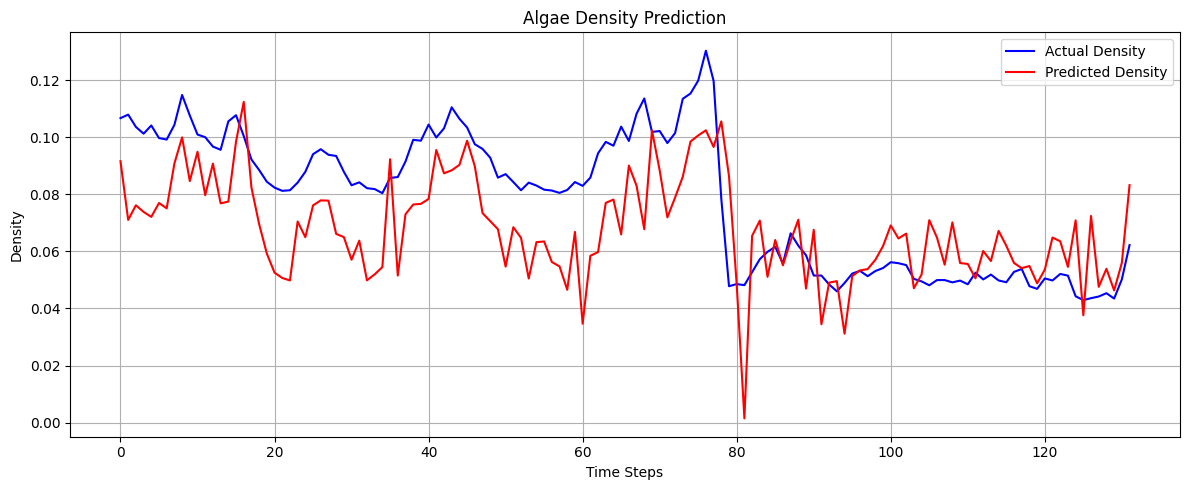

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import logging

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out
    
def preprocess_data(df, sequence_length, prediction_step=3):
    if 'date' in df.columns:
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)

    df = df.ffill()

    # 对weather列进行独热编码
    if 'weather' in df.columns:
        weather_dummies = pd.get_dummies(df['weather'], prefix='weather')
        df = pd.concat([df, weather_dummies], axis=1)
        df.drop('weather', axis=1, inplace=True)

    # 获取藻密度的TOP10特征
    sorted_features = sorted(feature_importance['density_mean_y'].items(), 
                           key=lambda x: x[1]['composite_score'], 
                           reverse=True)[:10]
    density_features = [feature[0] for feature in sorted_features]
    
    # 检查特征是否存在于数据集中
    available_features = [f for f in density_features if f in df.columns]
    logging.info(f"Number of density features: {len(available_features)}")
    logging.info(f"Density features: {available_features}")
    
    # 添加目标变量
    available_features.append('density_mean_y')
    df_features = df[available_features]

    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df_features), columns=available_features, index=df.index)

    # 分割2024年前后的数据
    train_data = df_scaled[df_scaled.index.year < 2024]
    test_data = df_scaled[df_scaled.index.year >= 2024]

    # 创建训练序列
    train_sequences = []
    for i in range(len(train_data) - sequence_length - prediction_step + 1):
        train_sequences.append(train_data.iloc[i:i+sequence_length].values)
    train_sequences = np.array(train_sequences)

    # 创建测试序列
    test_sequences = []
    for i in range(len(test_data) - sequence_length - prediction_step + 1):
        test_sequences.append(test_data.iloc[i:i+sequence_length].values)
    test_sequences = np.array(test_sequences)

    # 分割输入和目标
    X_train = train_sequences[:, :-prediction_step, :]
    y_train = train_sequences[:, -prediction_step, [available_features.index('density_mean_y')]]
    
    X_test = test_sequences[:, :-prediction_step, :]
    y_test = test_sequences[:, -prediction_step, [available_features.index('density_mean_y')]]

    return X_train, y_train, X_test, y_test, scaler, available_features

def create_dataloaders(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(torch.Tensor(X_train), torch.Tensor(y_train))
    test_dataset = TensorDataset(torch.Tensor(X_test), torch.Tensor(y_test))

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

def train_lstm_model(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        if (epoch + 1) % 10 == 0:
            logging.info(f'Epoch {epoch+1}/{epochs}, Average Loss for target 1: {avg_loss:.4f}')

def evaluate_lstm_model(model, test_loader):
    model.eval()
    predictions = []
    targets = []
    with torch.no_grad():
        for inputs, target in test_loader:
            output = model(inputs)
            predictions.append(output.numpy())
            targets.append(target.numpy())
    predictions = np.concatenate(predictions)
    targets = np.concatenate(targets)
    return predictions, targets

def plot_forecast(targets, predictions, title='Prediction Results', start_idx=0, end_idx=None):
    if end_idx is None:
        end_idx = len(targets)
        
    plt.figure(figsize=(12, 5))
    plt.plot(targets[start_idx:end_idx], label='Actual Density', color='blue')
    plt.plot(predictions[start_idx:end_idx], label='Predicted Density', color='red')
    plt.title('Algae Density Prediction')
    plt.xlabel('Time Steps')
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def main():
    try:
        df = pd.read_csv('/root/Download/Modis-algae-aliyun/AlgaeBloomForecast-20241107/merged_all_data_filtered.csv')
        logging.info("Successfully loaded data file")

        batch_size = 32
        hidden_size = 128
        num_layers = 2
        output_size = 1  # 只预测藻密度
        criterion = nn.MSELoss()
        epochs = 200
        prediction_step = 7  # 预测未来7天
        sequence_length = 14  # 使用过去14天数据

        logging.info(f"Start training model, sequence length: {sequence_length}, prediction steps: {prediction_step}")
        X_train, y_train, X_test, y_test, scaler, features = preprocess_data(df, sequence_length, prediction_step)
        input_size = len(features)

        train_loader, test_loader = create_dataloaders(X_train, y_train, X_test, y_test, batch_size)

        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

        train_lstm_model(model, train_loader, criterion, optimizer, epochs)

        predictions, targets = evaluate_lstm_model(model, test_loader)

        # 计算RMSE和MAE
        rmse_density = np.sqrt(mean_squared_error(targets, predictions))
        mae_density = mean_absolute_error(targets, predictions)

        logging.info("\nPrediction Accuracy Evaluation:")
        logging.info(f"Algae Density RMSE: {rmse_density:.4f}, MAE: {mae_density:.4f}")

        # 绘制预测结果
        plot_forecast(targets, predictions, title='LSTM Prediction Results')

    except Exception as e:
        logging.error(f"Program error: {str(e)}")
        import traceback
        logging.error(traceback.format_exc())

if __name__ == "__main__":
    main()